In [1]:
import numpy as np
from numpy.random import RandomState

SEED = 42
rng = RandomState(SEED)  # Allows us to have repeatable randomness
from numba import jit, njit, cuda

from qiskit import QuantumCircuit, Aer

backend = Aer.get_backend("statevector_simulator")

from timeit import timeit

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, rcParamsDefault

rcParams.update(rcParamsDefault)
rc('text', usetex=True)
import scienceplots

plt.style.use(["science"])

from datetime import datetime
import pickle

In [2]:
@njit
def nf(state, U, q0, q1, N):
    # Swap affected qubits if necessary
    assert q0 < q1
    # if q0 > q1:
    #     U = swap_two_qubit_gate(U)
    #     q0, q1 = q1, q0

    for i0 in range(1 << q0):
        # TODO: consider incrementing by the correct amount here rather than doing the multiplication below to get l.
        for i1 in range(1 << (q1 - q0 - 1)):
            for i2 in range(1 << ((N - 1) - q1)):
                l = i0 + (1 << (q0 + 1)) * i1 + (1 << (q1 + 1)) * i2

                j00 = l
                j01 = l + (1 << q0)
                j10 = l + (1 << q1)
                j11 = l + (1 << q1) + (1 << q0)

                j = np.array([j00, j01, j10, j11])
                # Update all alpha_js by applying the U gate
                state[j] = np.dot(U, state[j])
                # Replace the alpha_js in the state vector

In [3]:
@jit
def nf_single(state, U, q0, N):
    for i0 in range(1 << q0):
        for i1 in range(1 << ((N - 1) - q0)):
            l = i0 + (1 << (q0 + 1)) * i1
            # Create vector of the indices of the relevant probability amplitudes.
            j0 = l
            j1 = l + (1 << q0)

            j = np.array([j0, j1])
            # Update all alpha_js by applying the U gate
            state[j] = U @ state[j]


In [4]:
@njit(parallel=True)
def nf_parallel(state, U, q0, q1, N):
    # Swap affected qubits if necessary
    assert q0 < q1
    # if q0 > q1:
    #     U = swap_two_qubit_gate(U)
    #     q0, q1 = q1, q0

    for i0 in range(1 << q0):
        # TODO: consider incrementing by the correct amount here rather than doing the multiplication below to get l.
        for i1 in range(1 << (q1 - q0 - 1)):
            for i2 in range(1 << ((N - 1) - q1)):
                l = i0 + (1 << (q0 + 1)) * i1 + (1 << (q1 + 1)) * i2

                j00 = l
                j01 = l + (1 << q0)
                j10 = l + (1 << q1)
                j11 = l + (1 << q1) + (1 << q0)

                j = np.array([j00, j01, j10, j11])
                # Update all alpha_js by applying the U gate
                state[j] = np.dot(U, state[j])


In [5]:
def f(state, U, q0, q1, N):
    assert q0 < q1
    # if q0 > q1:
    #     U = swap_two_qubit_gate(U)
    #     q0, q1 = q1, q0
    for i0 in range(1 << q0):
        # TODO: consider incrementing by the correct amount here rather than doing the multiplication below to get l.
        for i1 in range(1 << (q1 - q0 - 1)):
            for i2 in range(1 << ((N - 1) - q1)):
                l = i0 + (1 << (q0 + 1)) * i1 + (1 << (q1 + 1)) * i2

                j00 = l
                j01 = l + (1 << q0)
                j10 = l + (1 << q1)
                j11 = l + (1 << q1) + (1 << q0)

                j = np.array([j00, j01, j10, j11])
                # Update all alpha_js by applying the U gate
                state[j] = np.dot(U, state[j])
                # Replace the alpha_js in the state vector



In [6]:
def Itensor(k):
    return np.eye(2 ** k)


def kron(*matrices):
    M = matrices[0]
    for i in range(len(matrices) - 1):
        M = np.kron(M, matrices[i + 1])
    return M


def f_naive(state, q0, q1, N):
    X = np.array([[0, 1], [1, 0]])
    control0 = np.array([[1, 0], [0, 0]])
    control1 = np.array([[0, 0], [0, 1]])
    # Construct matrix
    U = kron(Itensor((N - 1) - q0), control0, Itensor(q0)) + kron(Itensor((N - 1) - q1), X, Itensor(
        q1 - q0 - 1), control1, Itensor(q0))
    # Apply matrix to state
    U @ state

In [7]:
def nf_cuda(state, U, q0, q1, N, dtype):
    # Swap affected qubits if necessary
    assert q0 < q1

    # if q0 > q1:
    #     U = swap_two_qubit_gate(U)
    #     q0, q1 = q1, q0
    @jit(target_backend="cuda")
    def mutate():
        for i0 in range(1 << q0):
            # TODO: consider incrementing by the correct amount here rather than doing the multiplication below to get l.
            for i1 in range(1 << (q1 - q0 - 1)):
                for i2 in range(1 << ((N - 1) - q1)):
                    l = i0 + (1 << (q0 + 1)) * i1 + (1 << (q1 + 1)) * i2

                    j00 = l
                    j01 = l + (1 << q0)
                    j10 = l + (1 << q1)
                    j11 = l + (1 << q1) + (1 << q0)

                    j = np.array([j00, j01, j10, j11])
                    # Update all alpha_js by applying the U gate
                    state[j] = np.dot(U, state[j])

    mutate()



In [7]:
def time_me(N, case, dtype):
    state = np.zeros(2 ** N, dtype=dtype)
    state[0] = 1
    state[1] = 1
    state *= 1 / np.sqrt(2)

    CNOT = np.array([
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0]
    ], dtype=dtype)

    s = state.copy()
    for i in range(1, N):
        if case == "numba":
            nf(s, CNOT, 0, i, N)
        elif case == "parallel":
            nf_parallel(s, CNOT, 0, i, N)
        elif case == "cuda":
            nf_cuda(s, CNOT, 0, i, N, dtype)
        elif case == "plain":
            f(s, CNOT, 0, i, N)
        elif case == "naive":
            f_naive(s, 0, i, N)


def setup_quantum(N):
    c = QuantumCircuit(N)
    c.h(0)
    for i in range(1, N):
        c.cnot(0, i)

    return c


def qiskit_time(N, c):
    job = backend.run(c)
    result = job.result()
    outputstate = result.get_statevector()


def time_all(N):
    cq = setup_quantum(N)
    return dict({
        # "Naive": timeit(lambda: time_me(N, "naive", dtype=np.complex64), number=trials),
        # "In-place Mutation": timeit(lambda: time_me(N, "plain", dtype=np.complex64), number=trials),
        #  timeit(lambda: time_me(N, "cuda", dtype=np.float64), number=trials))
        "Numba / Cuda Optimized": timeit(lambda: time_me(N, "numba", dtype=np.complex64), number=trials),
        "Qiskit": timeit(lambda: qiskit_time(N, cq), number=trials),
    })


trials = 1
N_MAX = 25
Ns = range(1, N_MAX + 1)
df = pd.DataFrame([time_all(N) for N in Ns])
df /= trials * 1e-3


KeyboardInterrupt: 

In [ ]:
df.to_pickle(f"Data/no_naive_no_mutation_N=25-{datetime.now():%Y-%m-%d-%H:%M:%S}")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=400, figsize=(4, 3))
for col in df:
    plt.plot(range(1, N_MAX + 1), df[col], "o-", label=col)

plt.title("Average Runtime of Quantum Simulators")
plt.ylabel("Average Runtime (ms)")
plt.xlabel("N")
plt.xticks(range(1, N_MAX + 1, 2))
legend = plt.legend(frameon=1, framealpha=0.8)
plt.grid()

plt.savefig(f"Plots/fig-{datetime.now():%Y-%m-%d-%H:%M:%S}.png", dpi=400, bbox_inches="tight", pad_inches=1)
plt.show()

In [8]:
# Create arbitrary circuits of depth d
# Define inverse sqrt(2) for convenience (not actually used...)
INV2 = 1 / np.sqrt(2)

# Define common quantum logic gates
# Pauli Gates
I = np.eye(2)
X = np.array([[0, 1], [1, 0]], dtype=np.complex64)
Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex64)
Z = np.array([[1, 0], [0, -1]], dtype=np.complex64)

# Clifford Gates
H = np.array([[1, 1], [1, -1]], dtype=np.complex64)  # Don't forget the factor of 2^(-1/2)

# T Gate
T = np.array([
    [1, 0],
    [0, np.exp(1j * np.pi / 4)]
], dtype=np.complex64)

CZ = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, -1],
], dtype=np.complex64)

operator_dict = dict({
    "I": I,
    "X": X,
    "Y": Y,
    "Z": Z,
    "H": H,
    "T": T,
    "CZ": CZ,
})


In [16]:
def setup_circuit(num_qubits, d):
    # Define the available operators and the associated weights of the probability of picking each one
    operators = ["I", "X", "Y", "Z", "H", "T", "CZ"]
    weights = np.array([4, 1, 1, 1, 1, 2, 1])
    weights = weights / np.sum(weights)

    circuit_array = []
    CZ_indices = []
    for N in range(num_qubits):
        qubit_gates = []
        for i in range(d):
            idx = rng.choice(np.arange(len(operators)), replace=True, p=weights)  # Create random circuit
            if idx == len(operators) - 1:  # If CZ was picked
                if N < num_qubits - 2:  # Only add CZ if its possible to do so incrementally (TODO: allow reverse CZ)
                    control = N
                    target = rng.randint(control + 1, num_qubits - 1)
                    CZ_indices.append((control, target))
                    qubit_gates.append(operators[idx])
            else:
                qubit_gates.append(operators[idx])
        circuit_array.append(qubit_gates)
    print(f"Circuit generated. (N = {num_qubits}, d={d})")
    return circuit_array, CZ_indices


def setup_quantum(num_qubits, circuit_array, CZ_indices):
    # Create qiskit circuit
    qc = QuantumCircuit(num_qubits)
    CZ_idx = 0
    for qi, qubit_circuits in enumerate(circuit_array):
        for circuit in qubit_circuits:
            if circuit == "CZ":  # qiskit has no .cz() method
                control, target = CZ_indices[CZ_idx]
                qc.h(target)
                qc.cnot(control, target)
                qc.h(target)
                CZ_idx += 1
            else:
                if circuit == "X":
                    qc.x(qi)
                if circuit == "Y":
                    qc.y(qi)
                if circuit == "Z":
                    qc.z(qi)
                if circuit == "H":
                    qc.h(qi)
                if circuit == "T":
                    qc.t(qi)
    print("Quantum Circuit Setup")
    return qc


def execute_qiskit(qiskit_circuit):
    job = backend.run(qiskit_circuit)
    result = job.result()
    outputstate = result.get_statevector()
    return outputstate


def execute_schroedinger(state, circuit_array, CZ_indices):
    CZ_idx = 0
    p = 0  # Global power of 2 (1 / 2^p)
    for qi, qubit_circuits in enumerate(circuit_array):
        for circuit in qubit_circuits:
            if circuit == "CZ":
                control, target = CZ_indices[CZ_idx]
                nf(state, CZ, control, target, N)
                CZ_idx += 1
            else:
                if circuit == "X":
                    nf_single(state, X, qi, N)
                if circuit == "Y":
                    nf_single(state, Y, qi, N)
                if circuit == "Z":
                    nf_single(state, Z, qi, N)
                if circuit == "H":
                    p += 1
                    nf_single(state, H, qi, N)
                if circuit == "T":
                    nf_single(state, T, qi, N)
    # Add global power of two back into state vector
    state *= np.power(2, -p / 2)
    return state

In [36]:
# Check output against qiskit
for N in range(1, 26):
    for d in range(10, 11):
        # Generate a random circuit with N qubits and depth d
        circuit_array, CZ_indices = setup_circuit(N, d)
        # Convert this circuit to a qiskit ciruit
        qiskit_circuit = setup_quantum(N, circuit_array, CZ_indices)

        # Create state vector for Schroedinger simulation.
        state0 = np.zeros(2 ** N, dtype=np.complex64)
        state0[0] = 1
        state = state0.copy()

        outputstate_qiskit = execute_qiskit(qiskit_circuit)
        outputstate_schroedinger = execute_schroedinger(state, circuit_array, CZ_indices)

        outputs_close = np.allclose(outputstate_qiskit, outputstate_schroedinger)
        print(outputs_close)
        assert outputs_close, f"Outputs not clsoe for N={N}"
print("All circuits passed check.")

Circuit generated. (N = 1, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 2, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 3, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 4, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 5, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 6, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 7, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 8, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 9, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 10, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 11, d=10)
Quantum Circuit Setup
True
All circuits passed check.
Circuit generated. (N = 12, d=10)
Quantum

In [20]:
def time_qiskit(qiskit_circuit):
    print("Running quantum timing.")
    execute_qiskit(qiskit_circuit)


# Compute regular circuit
def time_schroedinger(state, circuit_array, CZ_indices):
    print("Running classical timing.")
    state = execute_schroedinger(state, circuit_array, CZ_indices)


def time_all(N, d):
    # Generate a random circuit with N qubits and depth d
    circuit_gates, CZ_indices = setup_circuit(N, d)
    # Convert this circuit to a qiskit ciruit
    qiskit_circuit = setup_quantum(N, circuit_gates, CZ_indices)

    # Create state vector for Schroedinger simulation.
    state0 = np.zeros(2 ** N, dtype=np.complex64)
    state0[0] = 1
    state = state0.copy()

    return dict({
        # "Naive": timeit(lambda: time_me(N, "naive", dtype=np.complex64), number=trials),
        # "In-place Mutation": timeit(lambda: time_me(N, "plain", dtype=np.complex64), number=trials),
        #  timeit(lambda: time_me(N, "cuda", dtype=np.float64), number=trials))
        "Numba / Cuda Optimized": timeit(lambda: time_schroedinger(state, circuit_gates, CZ_indices), number=trials),
        "Qiskit": timeit(lambda: time_qiskit(qiskit_circuit), number=trials),
    }), qiskit_circuit


trials = 1
# ds = range(1, D_MAX + 1)
# Ns = range(1, N_MAX + 1)
Ns = range(1, 10)
depth = 5
ds = [depth] * len(Ns)  # setup number of layers
N_MAX = max(Ns)
D_MAX = max(ds)

timing_dicts, qcs = [], []
for N, d in zip(Ns, ds):
    timing_dict, qc = time_all(N, d)
    timing_dicts.append(timing_dict)
    qcs.append(qc)
# timings = [time_all(N, d) for N in Ns]
# df = pd.DataFrame([time_all(N, d) for d in ds])
df = pd.DataFrame(timing_dicts)
df /= trials * 1e-3  # convert to ms

Circuit generated. (N = 1, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 2, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 3, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 4, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 5, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 6, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 7, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 8, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.
Circuit generated. (N = 9, d=5)
Quantum Circuit Setup
Running classical timing.
Running quantum timing.


In [21]:
df

,Numba / Cuda Optimized,Qiskit
0,0.034341,0.677888
1,0.032471,0.406261
2,0.048251,0.650028
3,0.051211,0.404201
4,0.108472,0.411881
5,0.128914,0.550164
6,0.311308,0.602216
7,0.461292,0.442682
8,1.018757,0.536154


In [67]:
# pickle dataframe and quantum circuits for future use
df.to_pickle(f"Data/N=25-d=40-{datetime.now():%Y-%m-%d-%H:%M:%S}")
with open(f"Data/circuits-N=25-d=40-{datetime.now():%Y-%m-%d-%H:%M:%S}.pkl", "wb") as f:
    pickle.dump(qcs, f, protocol=pickle.HIGHEST_PROTOCOL)

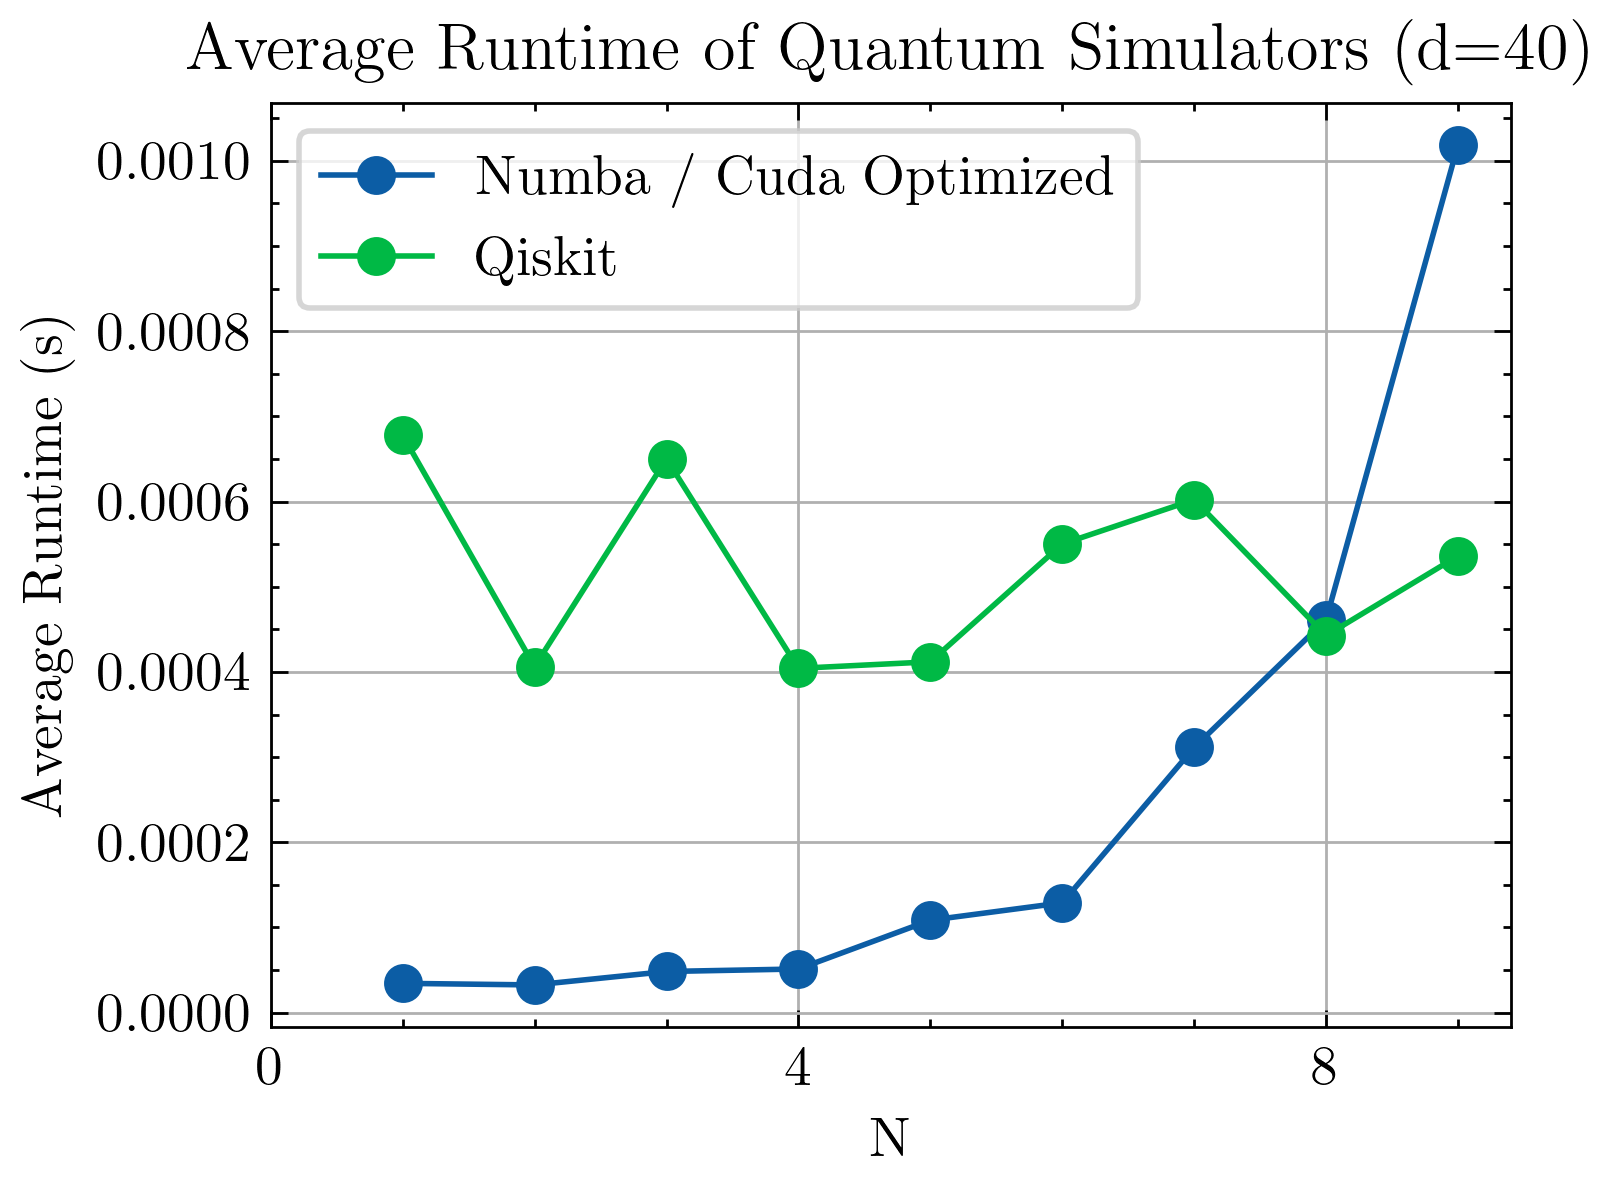

In [22]:
fig, ax = plt.subplots(1, 1, dpi=400, figsize=(4, 3))
x_range = Ns
for col in df:
    plt.plot(x_range, df[col] / 1e3, "o-", label=col)

plt.title("Average Runtime of Quantum Simulators (d=40)")
plt.ylabel("Average Runtime (s)")
plt.xlabel("N")
plt.xticks(range(0, N_MAX + 1, 4))
legend = plt.legend(frameon=1, framealpha=0.8)
plt.grid()

plt.savefig(f"Plots/fig-{datetime.now():%Y-%m-%d-%H:%M:%S}.png", dpi=400, bbox_inches="tight", pad_inches=0.1)
plt.show()


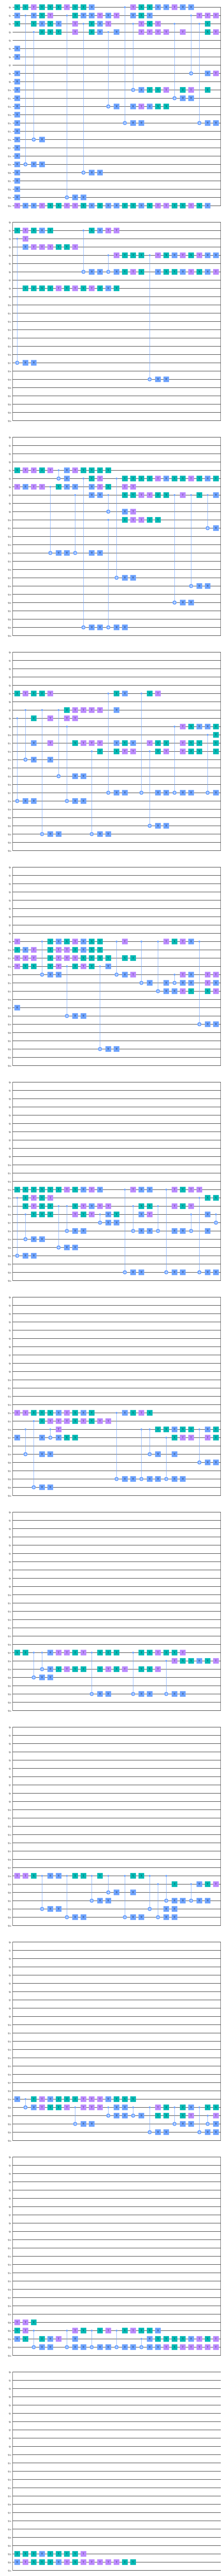

In [71]:
# Graph the circuit used when simulating N qubits and save it to a file
N = 10
d = 40
qcs[N - 1].draw(output="mpl", filename=f"Plots/circuit_diagram-N={N}-d={d}-{datetime.now():%Y-%m-%d-%H:%M:%S}")